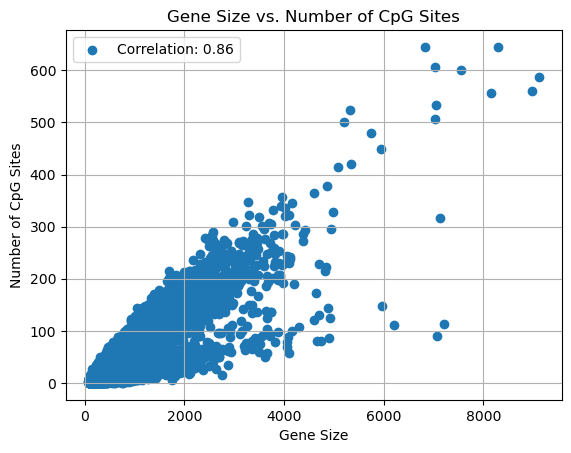

In [299]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np
import pickle
data = pickle.load(open("gene_CpG_test.p", "rb"))
sorted_by_gene = sorted(data, key=lambda tup: tup[1])

# Extract gene size and CpG count into separate lists
gene_size = np.array([item[1] for item in sorted_by_gene])
cpg_count = np.array([item[0] for item in sorted_by_gene])
sample = [item[2] for item in sorted_by_gene]
gene_id = [item[3] for item in sorted_by_gene]
meth_state = [item[4] for item in sorted_by_gene]
CpG_OE = [item[5] for item in sorted_by_gene]
# Calculate the correlation coefficient
correlation = np.corrcoef(gene_size, cpg_count)[0, 1]

# Create a scatter plot with lines connecting the points
plt.scatter(gene_size, cpg_count, label=f'Correlation: {correlation:.2f}')
plt.xlabel('Gene Size')
plt.ylabel('Number of CpG Sites')
plt.title('Gene Size vs. Number of CpG Sites')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [319]:
avg_CpG = np.average(np.array([el for el in CpG_OE if el]))
print (avg_CpG)
dev_CpG = []
gene_acc = []
gene_meth = []
actual_CpG = []
actual_meth = []
sample_CpG = defaultdict(list)
samples_uni = set()
for pos, el in enumerate(CpG_OE):
    if el:
        sample_id = sample[pos]
        samples_uni.add(sample_id)
        dev_CpG.append(el - avg_CpG)
        sample_CpG[sample_id].append((el-avg_CpG, gene_id[pos]))
        gene_acc.append(gene_id[pos])
        gene_meth.append(meth_state[pos])
        if meth_state[pos]:
            actual_meth.append(meth_state[pos])
            actual_CpG.append(el)
    else:
        pass
pos_sorted = sorted(enumerate(dev_CpG), key=lambda tup: tup[1])
print (len(gene_meth), len([el for el in gene_meth if el]))
from scipy import stats
correlation_coefficient, p_value = stats.pearsonr(np.array(actual_CpG), np.array(actual_meth))
print (correlation_coefficient, p_value)
print (len(actual_CpG))
print (samples_uni)
dataset_bi = []
dataset_all = []
dataset_sample = defaultdict(list)
dataset_clusters = []
cnt = 0
for pos, el in enumerate(CpG_OE):
    if el:
        cnt += 1
        dataset_sample[sample[pos]].append(el)
        if meth_state[pos]:
            dataset_all.append((el, meth_state[pos]))
            dataset_clusters.append((el, meth_state[pos]))
            if meth_state[pos] <= 0.05:
                dataset_bi.append((el, 0))
            if meth_state[pos] >= 0.56:
                dataset_bi.append((el, 1))
print (len(dataset_bi), cnt)
import pickle
pickle.dump(dataset_sample, open("dataset_sample.p", "wb"))
pickle.dump(dataset_bi, open("dataset_bi.p", "wb"))
pickle.dump(dataset_all, open("dataset_mixed.p", "wb"))
pickle.dump(dataset_clusters, open("datasets_clusters.p", "wb"))

0.7917721388311463
16692 15328
-0.50277886827615 0.0
15328
{'sample_58', 'sample_70', 'sample_108', 'sample_57', 'sample_115'}
11011 16692


In [301]:
acc2desc = pickle.load(open("test_genes_desc.p", "rb"))
from keybert import KeyBERT
kw_model = KeyBERT()
limit = 100
keywords_met = []
keywords_unmet = []
for samp_id in sample_CpG.keys():
    meth = []
    un_meth = []
    sorted_extreme = sorted(sample_CpG[samp_id], key=lambda tup: tup[1])
    cnt = 0
    print (samp_id)
    for el in sorted_extreme:
        acc = el[1].split("|")[0]
        if acc2desc.get(acc, None):
            meth += [x[1] for x in acc2desc[acc]]
            cnt += 1
            if cnt == limit:
                break
    sorted_extreme.reverse()
    cnt = 0
    for el in sorted_extreme:
        acc = el[1].split("|")[0]
        if acc2desc.get(acc, None):
            un_meth += [x[1] for x in acc2desc[acc]]
            cnt += 1
            if cnt == limit:
                break
    text_meth = " ".join(meth)
    text_unmeth = " ".join(un_meth)
    keywords_low = kw_model.extract_keywords(text_meth, top_n=200)
    keywords_high = kw_model.extract_keywords(text_unmeth, top_n=200)
    keywords_met.append(set([el[0] for el in keywords_low[0:100]]))
    keywords_unmet.append(set([el[0] for el in keywords_high[0:100]]))
meth_shared = set.intersection(*keywords_met)
unmet_shared = set.intersection(*keywords_unmet)
print ("METH", meth_shared.difference(unmet_shared))
print ("UN_METH", unmet_shared.difference(meth_shared))
print ("SHARED", meth_shared.intersection(unmet_shared))
    

sample_115
sample_108
sample_70
sample_58
sample_57
METH {'endopeptidase', 'helicase', 'kinase', 'biosynthetic', 'phosphorylation'}
UN_METH {'binding', 'activity', 'zinc', 'cytoplasm', 'ribosome', 'methyltransferase', 'metabolic', 'calcium', 'intracellular', 'membrane', 'cell', 'structural', 'nucleus'}
SHARED {'proteolysis', 'polymerase', 'transmembrane', 'nucleic', 'protein', 'rna', 'transcription', 'atp'}


In [317]:
meth_high = []
meth_low = []
counter = 100
for el in pos_sorted:
    if gene_meth[el[0]]:
        meth_high.append(gene_meth[el[0]])
        if len(meth_high) == 1000:
            break
pos_sorted.reverse()
for el in pos_sorted:
    if gene_meth[el[0]]:
        meth_low.append(gene_meth[el[0]])
        if len(meth_low) == 1000:
            break
avg_low = sum(meth_low)/len(meth_low)
avg_high = sum(meth_high)/len(meth_high)
print (len(meth_high), len(meth_low))

1000 1000


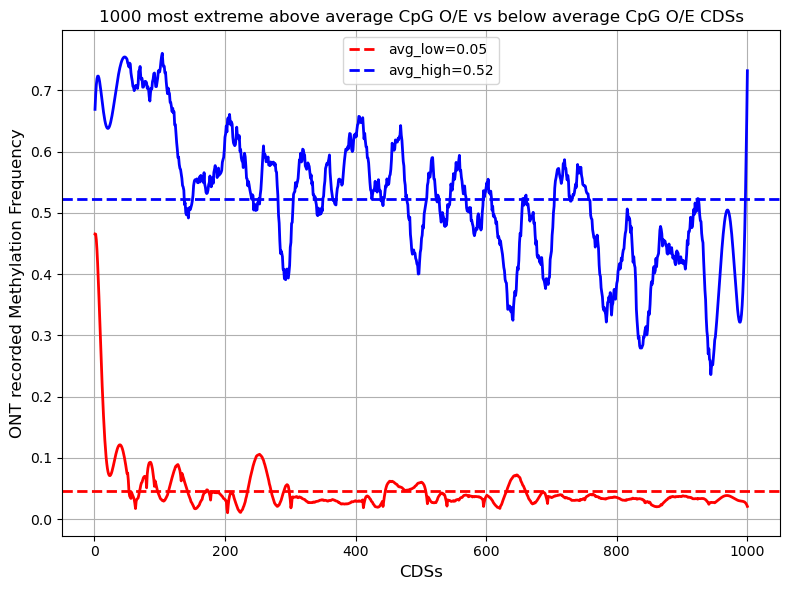

In [318]:
from scipy.signal import savgol_filter
# Define the two lists of floats
x_values = range(1, 1001)  # Assuming list1 and list2 have the same length
list1 = meth_low
list2 = meth_high
# Smooth the data using Savitzky-Golay filter
window_size = 99  # Window size for the filter
order = 7  # Order of the filter

s_list1 = savgol_filter(list1, window_size, order)
s_list2 = savgol_filter(list2, window_size, order)
# Create the scatter plot with lines connecting dots
plt.figure(figsize=(8, 6))  # Set the figure size

#plt.scatter(x_values, s_list1, color='blue', label='List1')  # Plot list1 data points in blue
plt.plot(x_values, s_list1, color='red', linestyle='-', linewidth=2)  # Connect list1 data points with blue line

#plt.scatter(x_values, s_list2, color='red', label='List2')  # Plot list2 data points in red
plt.plot(x_values, s_list2, color='blue', linestyle='-', linewidth=2)  # Connect list2 data points with red line
plt.axhline(y=avg_low, color='red', linestyle='--', linewidth=2, label='avg_low={:.2f}'.format(avg_low))  
plt.axhline(y=avg_high, color='blue', linestyle='--', linewidth=2, label='avg_high={:.2f}'.format(avg_high))  
# Add labels and title
plt.xlabel('CDSs', fontsize=12)
plt.ylabel('ONT recorded Methylation Frequency', fontsize=12)
plt.title('1000 most extreme above average CpG O/E vs below average CpG O/E CDSs')

# Add legend
plt.legend()

# Show the plot
plt.grid(True)  # Add grid for better readability
plt.tight_layout()  # Adjust layout to fit all elements
plt.show()

In [320]:
# Fit a linear regression model
slope, intercept, r_value, p_value, std_err = linregress(gene_size, cpg_count)

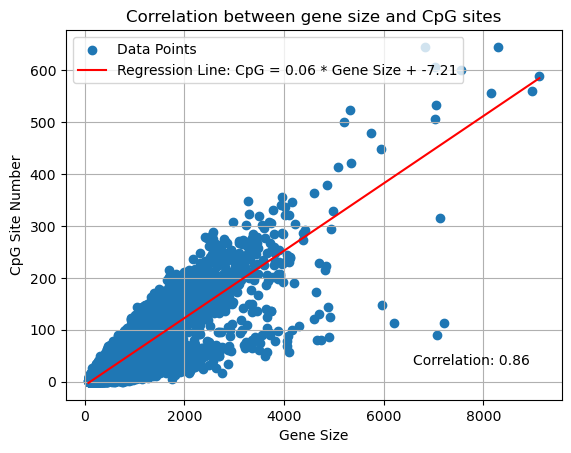

In [321]:
# Create a scatter plot of the data
plt.scatter(gene_size, cpg_count, label='Data Points')

# Plot the regression line
regression_line = slope * gene_size + intercept
plt.plot(gene_size, regression_line, color='red', label=f'Regression Line: CpG = {slope:.2f} * Gene Size + {intercept:.2f}')
# Set axis labels and a legend
plt.xlabel('Gene Size')
plt.ylabel('CpG Site Number')
plt.legend()
# Add the correlation value in the lower right corner
correlation_text = f'Correlation: {correlation:.2f}'
plt.title("Correlation between gene size and CpG sites")
plt.text(max(gene_size) * 0.85, max(cpg_count) * 0.05, correlation_text, fontsize=10, ha='center')
# Show the plot
plt.grid(True)
plt.show()

In [256]:
# Predict the expected CpG count for a given gene size
gene_size_to_predict = np.array([150, 200, 250])  # Change these to the desired gene sizes
expected_cpg_count = np.round(slope * gene_size_to_predict + intercept).astype(int)

In [259]:
from collections import defaultdict
extremes = defaultdict(list)
# Calculate residuals (actual - predicted)
residuals = cpg_count - (slope * gene_size + intercept)

# Find the genes with the largest deviations
top_genes = np.argsort(residuals)[::-1]
print (len(top_genes))
dev_corr = []
meth_corr = []
# Print or display the top genes with the largest deviations
for gene_idx in top_genes:
    #gene_name = gene_names[gene_idx]  # Replace with your actual gene names
    deviation = residuals[gene_idx]
    sample_id = sample[gene_idx]
    idx = gene_id[gene_idx]
    meth_num = meth_state[gene_idx]
    if meth_state[gene_idx]:
        meth_corr.append(meth_state[gene_idx])
        dev_corr.append(cpg_count[gene_idx]/(slope * gene_size[gene_idx] + intercept))
    extremes[sample_id].append((deviation, idx, meth_num))
correlation_coefficient, p_value = stats.pearsonr(np.array(dev_corr), np.array(meth_corr))
print (correlation_coefficient, p_value)


16977
-0.015855383284808604 0.08553934177901265


In [247]:
top100 = defaultdict(dict)
for sample in extremes.keys():
    top100[sample]["high"] = [el for el in extremes[sample] if el[0] > 0]
    top100[sample]["low"] = [el for el in extremes[sample] if el[0] < 0]
for k in top100.keys():
    h = [el[2] for el in top100[k]["high"] if el[2]]
    l = [el[2] for el in top100[k]["low"] if el[2]]
    meth_low = [el for el in l if el >= 0.7]
    meth_high= [el for el in h if el >= 0.7]
    print (k, len(meth_low), "low")
    print (k, len(meth_high), "high")
    print ("#######")
    sum_high = (sum(h)/len(h))*100
    sum_low = (sum(l)/len(l))*100
    print (k, "high", sum_high, len(h))
    print (k, "low", sum_low, len(l))


sample_70 2 low
sample_70 1 high
#######
sample_70 high 3.707356115107914 5560
sample_70 low 6.0438983986747745 1811
sample_115 3 low
sample_115 2 high
#######
sample_115 high 10.46525423728815 236
sample_115 low 10.909511228533656 1514
sample_57 416 low
sample_57 167 high
#######
sample_57 high 73.46996047430831 253
sample_57 low 71.65605095541407 628
sample_58 515 low
sample_58 189 high
#######
sample_58 high 75.34275362318844 276
sample_58 low 71.08816091954026 870
sample_108 11 low
sample_108 4 high
#######
sample_108 high 24.97692307692308 91
sample_108 low 22.581609195402336 522


In [248]:
print (len(meth_low), len(meth_high))

11 4


In [250]:
acc2desc = pickle.load(open("test_genes_desc.p", "rb"))
from keybert import KeyBERT
kw_model = KeyBERT()
from wordcloud import WordCloud
sentences = {}
for k in top100.keys():
    sorted_high = sorted(top100[k]["high"], key=lambda tup: tup[0], reverse=True)
    sorted_low = sorted(top100[k]["low"], key=lambda tup: tup[0])
    high = []
    low = []
    cnt = 0
    for el in sorted_high:
        acc = el[1].split("|")[0]
        if acc2desc.get(acc, None):
            high += [x[1] for x in acc2desc[acc]]
            cnt += 1
            if cnt == 20:
                break
    cnt = 0
    for el in sorted_low:
        acc = el[1].split("|")[0]
        if acc2desc.get(acc, None):
            low += [x[1] for x in acc2desc[acc]]
            cnt += 1
            if cnt == 20:
                break
    text_low = " ".join(low)
    text_high = " ".join(high)
    sentences[k] = (text_low, text_high)
    keywords_low = kw_model.extract_keywords(text_low, top_n=100)
    keywords_high = kw_model.extract_keywords(text_high, top_n=100)
    print (k)
    print (keywords_high[0:5])
    print (keywords_low[0:5])
    print ("#########")
    """
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_low)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    """

sample_70
[('rna', 0.298), ('transcription', 0.2893), ('spliceosome', 0.2658), ('mrna', 0.263), ('enzyme', 0.2624)]
[('nucleic', 0.3267), ('rna', 0.277), ('nucleus', 0.262), ('dna', 0.2619), ('atp', 0.2559)]
#########
sample_115
[('atp', 0.3065), ('cytosine', 0.2708), ('macromolecule', 0.2682), ('dna', 0.2508), ('cells', 0.2004)]
[('spliceosome', 0.3261), ('ribonucleoside', 0.2691), ('kinase', 0.265), ('spliceosomal', 0.2474), ('atp', 0.2382)]
#########
sample_57
[('kinase', 0.309), ('dehydrogenase', 0.3054), ('dna', 0.2956), ('rna', 0.2881), ('spliceosome', 0.2862)]
[('nucleic', 0.2468), ('rna', 0.2235), ('nucleotide', 0.2084), ('dna', 0.206), ('ribonuclease', 0.19)]
#########
sample_58
[('transcription', 0.2892), ('chromatin', 0.2835), ('nucleic', 0.2789), ('kinase', 0.2682), ('nucleus', 0.2555)]
[('rna', 0.2873), ('nucleic', 0.2847), ('transcription', 0.28), ('dna', 0.2486), ('ribonuclease', 0.2024)]
#########
sample_108
[('transcription', 0.2022), ('helicase', 0.1943), ('dna', 0.17

In [177]:
# Program to measure the similarity between 
# two sentences using cosine similarity. 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

def semSim(X, Y):
    # tokenization 
    X_list = word_tokenize(X.lower()) 
    Y_list = word_tokenize(Y.lower()) 

    # sw contains the list of stopwords 
    sw = stopwords.words('english') 
    l1 =[];l2 =[] 

    # remove stop words from the string 
    X_set = {w for w in X_list if not w in sw} 
    Y_set = {w for w in Y_list if not w in sw} 

    # form a set containing keywords of both strings 
    rvector = X_set.union(Y_set) 
    for w in rvector: 
    	if w in X_set: l1.append(1) # create a vector 
    	else: l1.append(0) 
    	if w in Y_set: l2.append(1) 
    	else: l2.append(0) 
    c = 0

    # cosine formula 
    for i in range(len(rvector)): 
    	c += l1[i]*l2[i] 
    cosine = c / float((sum(l1)*sum(l2))**0.5) 
    print("similarity: ", cosine) 
    return cosine


In [178]:
high_combo = []
low_combo = []
for k in sentences.keys():
    print (k)
    low_combo.append(sentences[k][0])
    high_combo.append(sentences[k][1])
    #semSim(sentences[k][0], sentences[k][1])

sample_70
sample_115
sample_57
sample_58
sample_108


In [179]:
from itertools import combinations
list_high = []
list_low = []
for el in combinations(high_combo, 2):
    list_high.append(semSim(el[0], el[1]))
print ("#####")
for el in combinations(low_combo, 2):
    list_low.append(semSim(el[0], el[1])    )

similarity:  0.2946878675818801
similarity:  0.320973998196695
similarity:  0.32333706948180657
similarity:  0.34035122819557057
similarity:  0.35107344375178157
similarity:  0.22354977701776282
similarity:  0.5215925838520059
similarity:  0.3426901876863411
similarity:  0.28661838988431687
similarity:  0.44975020814061945
#####
similarity:  0.2986089093888467
similarity:  0.4633890050582481
similarity:  0.5
similarity:  0.3296902366978935
similarity:  0.26302131939952095
similarity:  0.2850357771438991
similarity:  0.6504757059781684
similarity:  0.6529572344002587
similarity:  0.2938832198999724
similarity:  0.25056457989039904


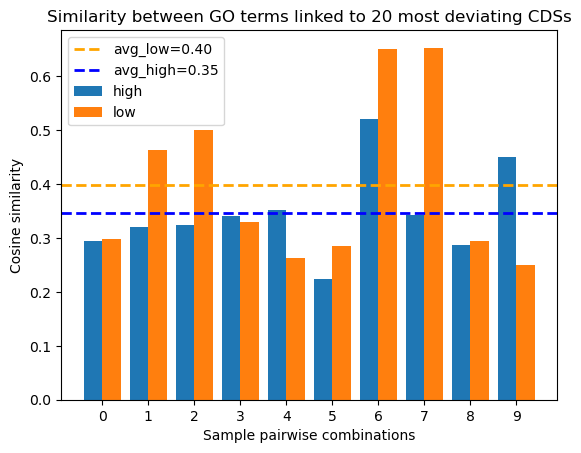

In [180]:
import numpy as np  
import matplotlib.pyplot as plt  
X = list(np.arange(len(list_high)))
X_axis = np.arange(len(list_high)) 
  
plt.bar(X_axis - 0.2, list_high, 0.4, label = 'high') 
plt.bar(X_axis + 0.2, list_low, 0.4, label = 'low') 
# Add a horizontal red line at y = 5
avg_high = sum(list_high)/len(list_high)
avg_low = sum(list_low)/len(list_low)
plt.axhline(y=avg_low, color='orange', linestyle='--', linewidth=2, label='avg_low={:.2f}'.format(avg_low))  
plt.axhline(y=avg_high, color='blue', linestyle='--', linewidth=2, label='avg_high={:.2f}'.format(avg_high))   
plt.xlabel("Sample pairwise combinations") 
plt.xticks(X_axis, X) 
plt.ylabel("Cosine similarity") 
plt.title("Similarity between GO terms linked to 20 most deviating CDSs") 
plt.legend() 
plt.show() 

similarity:  0.2669753499690384
similarity:  0.3103424142927039
similarity:  0.4314354222533741
similarity:  0.3442960742012873
similarity:  0.33624220961891704


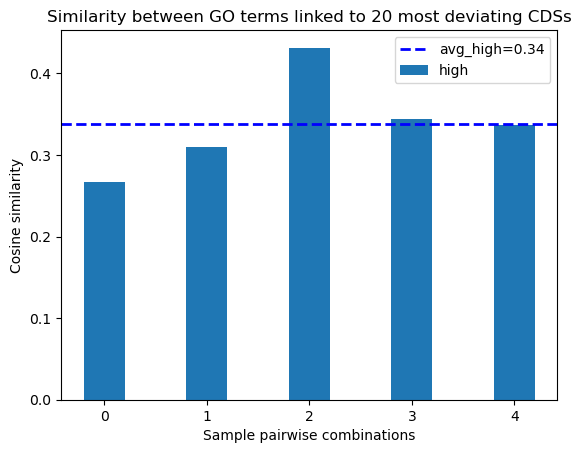

In [181]:
intrasample = []
for el in zip(high_combo, low_combo):
    intrasample.append(semSim(el[0], el[1]))
    
X_axis = np.arange(len(intrasample)) 
  
plt.bar(X_axis, intrasample, 0.4, label = 'high') 
# Add a horizontal red line at y = 5
avg_high = sum(intrasample)/len(intrasample)
plt.axhline(y=avg_high, color='blue', linestyle='--', linewidth=2, label='avg_high={:.2f}'.format(avg_high))  
plt.xlabel("Sample pairwise combinations") 
plt.ylabel("Cosine similarity") 
plt.title("Similarity between GO terms linked to 20 most deviating CDSs") 
plt.legend() 
plt.show() 

In [188]:
valid = [el for el in CpG_OE if el]
print (len(valid), len(CpG_OE))
print (sum(valid)/len(valid))

16692 16977
0.7917721388311408


In [189]:
valid[0:20]

[0.5454545454545454,
 0.7384615384615385,
 0.78125,
 0.78125,
 0.7183908045977011,
 0.3611111111111111,
 1.3866666666666667,
 0.4588235294117647,
 0.3611111111111111,
 1.3866666666666667,
 1.335164835164835,
 0.7714285714285715,
 0.45,
 1.3695652173913044,
 0.7714285714285715,
 0.4487534626038781,
 0.8571428571428571,
 1.4285714285714286,
 0.7601809954751131,
 1.2444444444444445]

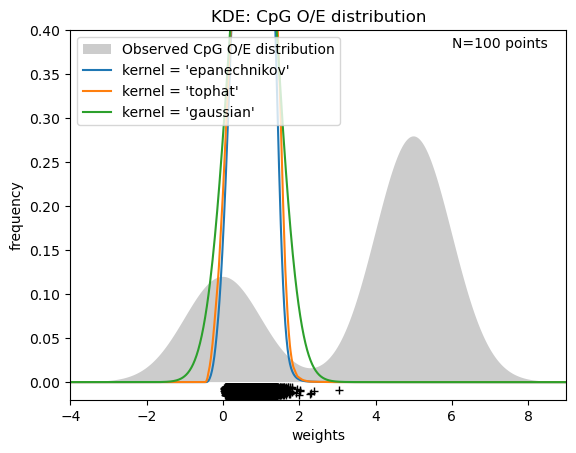

In [275]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.neighbors import KernelDensity

# Plot a 1D density example
N = 100
np.random.seed(1)
#X = np.concatenate((np.random.normal(0, 1, int(0.3 * N)),
#                    np.random.normal(5, 1, int(0.7 * N))))[:, np.newaxis]
X = np.array(valid)[:, np.newaxis]
X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]

true_dens = (0.3 * norm(0, 1).pdf(X_plot[:, 0])
             + 0.7 * norm(5, 1).pdf(X_plot[:, 0]))

fig, ax = plt.subplots()
ax.fill(X_plot[:, 0], true_dens, fc='black', alpha=0.2,
        label='Observed CpG O/E distribution')

for kernel in ['epanechnikov', 'tophat', 'gaussian']:
    kde = KernelDensity(kernel=kernel, bandwidth=0.5).fit(X)
    log_dens = kde.score_samples(X_plot)
    ax.plot(X_plot[:, 0], np.exp(log_dens), '-',
            label="kernel = '{0}'".format(kernel))

ax.text(6, 0.38, "N={0} points".format(N))
plt.title("KDE: CpG O/E distribution")
plt.xlabel("weights")
plt.ylabel("frequency")
ax.legend(loc='upper left')
ax.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), '+k')

ax.set_xlim(-4, 9)
ax.set_ylim(-0.02, 0.4)
plt.show()